#Import Data dari Kaggle

In [1]:
# Instal library yang dibutuhkan
!pip install kaggle
!pip install split-folders

# Import library
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import splitfolders
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import pathlib

In [2]:
print("Upload file kaggle.json Anda:")
uploaded = files.upload()

# Pindahkan file API ke direktori yang benar
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Upload file kaggle.json Anda:


Saving kaggle.json to kaggle.json


In [4]:
# Unduh dataset dari Kaggle
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 56% 122M/219M [00:00<00:00, 1.25GB/s]
100% 219M/219M [00:00<00:00, 850MB/s] 


In [5]:
# Ekstrak file zip
import zipfile
local_zip = 'rice-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/rice-dataset')
zip_ref.close()

print("Dataset beras berhasil diunduh dan diekstrak.")

Dataset beras berhasil diunduh dan diekstrak.


#Explorasi Data

###Explorasi Persebaran Data

In [6]:
# Tentukan path untuk setiap set data
Arborio_dir = "/content/rice-dataset/Rice_Image_Dataset/Arborio"
Basmati_dir = "/content/rice-dataset/Rice_Image_Dataset/Basmati"
Ipsala_dir = "/content/rice-dataset/Rice_Image_Dataset/Ipsala"
Jasmine_dir = "/content/rice-dataset/Rice_Image_Dataset/Jasmine"
Karacadag_dir = "/content/rice-dataset/Rice_Image_Dataset/Karacadag"

# Verifikasi jumlah gambar di setiap direktori (opsional)
print(f"Total gambar Arborio: {sum([len(files) for r, d, files in os.walk(Arborio_dir)])}")
print(f"Total gambar Basmati: {sum([len(files) for r, d, files in os.walk(Basmati_dir)])}")
print(f"Total gambar Ipsala: {sum([len(files) for r, d, files in os.walk(Ipsala_dir)])}")
print(f"Total gambar Jasmine: {sum([len(files) for r, d, files in os.walk(Jasmine_dir)])}")
print(f"Total gambar Karacadag: {sum([len(files) for r, d, files in os.walk(Karacadag_dir)])}")

Total gambar Arborio: 15000
Total gambar Basmati: 15000
Total gambar Ipsala: 15000
Total gambar Jasmine: 15000
Total gambar Karacadag: 15000


/tmp/ipython-input-3547859740.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_class_names, y=sorted_counts, palette="viridis")


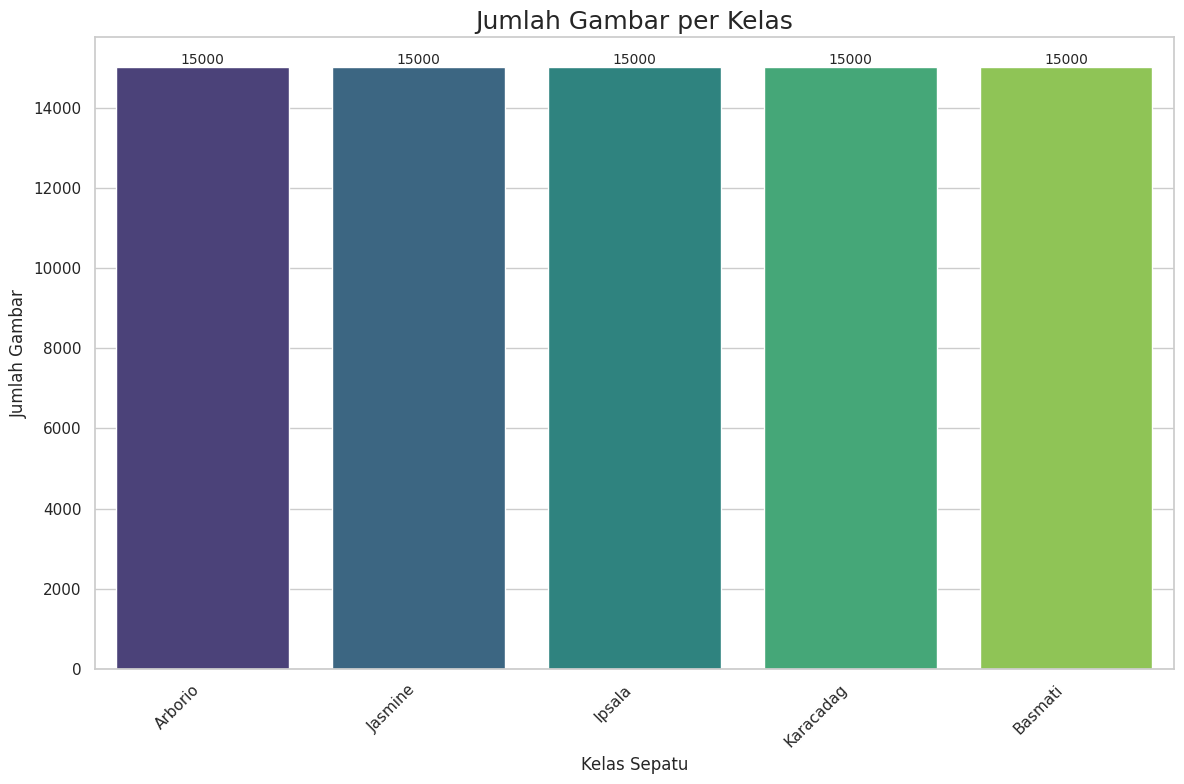

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tentukan path ke folder data Anda yang sudah digabung
data_dir = '/content/rice-dataset/Rice_Image_Dataset'

# 2. Siapkan dictionary untuk menyimpan jumlah gambar per kelas
class_counts = {}

# Pastikan direktori ada
if os.path.exists(data_dir):
    # Dapatkan nama semua kelas (subfolder)
    class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    # Hitung jumlah file di setiap folder kelas
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        num_files = len(os.listdir(class_path))
        class_counts[class_name] = num_files

    # Urutkan kelas berdasarkan jumlah gambar (dari terbanyak ke tersedikit)
    sorted_class_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)

    # Pisahkan nama kelas dan jumlahnya untuk plotting
    sorted_class_names = [item[0] for item in sorted_class_counts]
    sorted_counts = [item[1] for item in sorted_class_counts]

    # --- MEMBUAT VISUALISASI ---
    # Atur style plot agar lebih menarik
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    # Buat bar plot menggunakan seaborn
    ax = sns.barplot(x=sorted_class_names, y=sorted_counts, palette="viridis")

    # Tambahkan judul dan label
    plt.title('Jumlah Gambar per Kelas', fontsize=18)
    plt.xlabel('Kelas Sepatu', fontsize=12)
    plt.ylabel('Jumlah Gambar', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Putar label x agar tidak tumpang tindih

    # Tambahkan anotasi angka di atas setiap bar
    for index, value in enumerate(sorted_counts):
        plt.text(index, value + 20, str(value), ha='center', va='bottom', fontsize=10) # +20 untuk sedikit spasi

    # Tampilkan plot
    plt.tight_layout()
    plt.show()

else:
    print(f"Error: Direktori '{data_dir}' tidak ditemukan. Mohon periksa kembali path Anda.")

In [8]:
# Tentukan path direktori awal dan direktori tujuan
base_split_dir = '/content/rice-dataset/Rice_Image_Dataset'
output_split_dir = '/content/rice-dataset/split_data'

os.makedirs(output_split_dir, exist_ok=True)

# Bagi dataset dengan rasio 80:10:10
splitfolders.ratio(base_split_dir, output=output_split_dir, seed=42, ratio=(.7, .1, .2))

Copying files: 75000 files [00:09, 7811.96 files/s] 


In [10]:
import os

# Helper function to count files in a directory
def count_files(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len(files)
    return count

# 1. Tentukan path untuk setiap set data
train_dir = "/content/rice-dataset/split_data/train"
validation_dir = "/content/rice-dataset/split_data/val"
test_dir = "/content/rice-dataset/split_data/test"

# 2. Hitung jumlah gambar di setiap direktori
train_count = count_files(train_dir)
val_count = count_files(validation_dir)
test_count = count_files(test_dir)

# 3. Hitung total semua gambar
total_count = train_count + val_count + test_count

# 4. Hitung persentase untuk setiap set
# Menambahkan 'if total_count > 0' untuk menghindari pembagian dengan nol
if total_count > 0:
    train_percent = (train_count / total_count) * 100
    val_percent = (val_count / total_count) * 100
    test_percent = (test_count / total_count) * 100
else:
    train_percent, val_percent, test_percent = 0, 0, 0

# 5. Tampilkan hasilnya
print("Analisis Pembagian Dataset")
print(f"Total gambar train      : {train_count} ({train_percent:.1f}%)")
print(f"Total gambar validation : {val_count} ({val_percent:.1f}%)")
print(f"Total gambar test       : {test_count} ({test_percent:.1f}%)")
print(f"Total semua gambar      : {total_count} (100.0%)")

Analisis Pembagian Dataset
Total gambar train      : 52500 (70.0%)
Total gambar validation : 7500 (10.0%)
Total gambar test       : 15000 (20.0%)
Total semua gambar      : 75000 (100.0%)


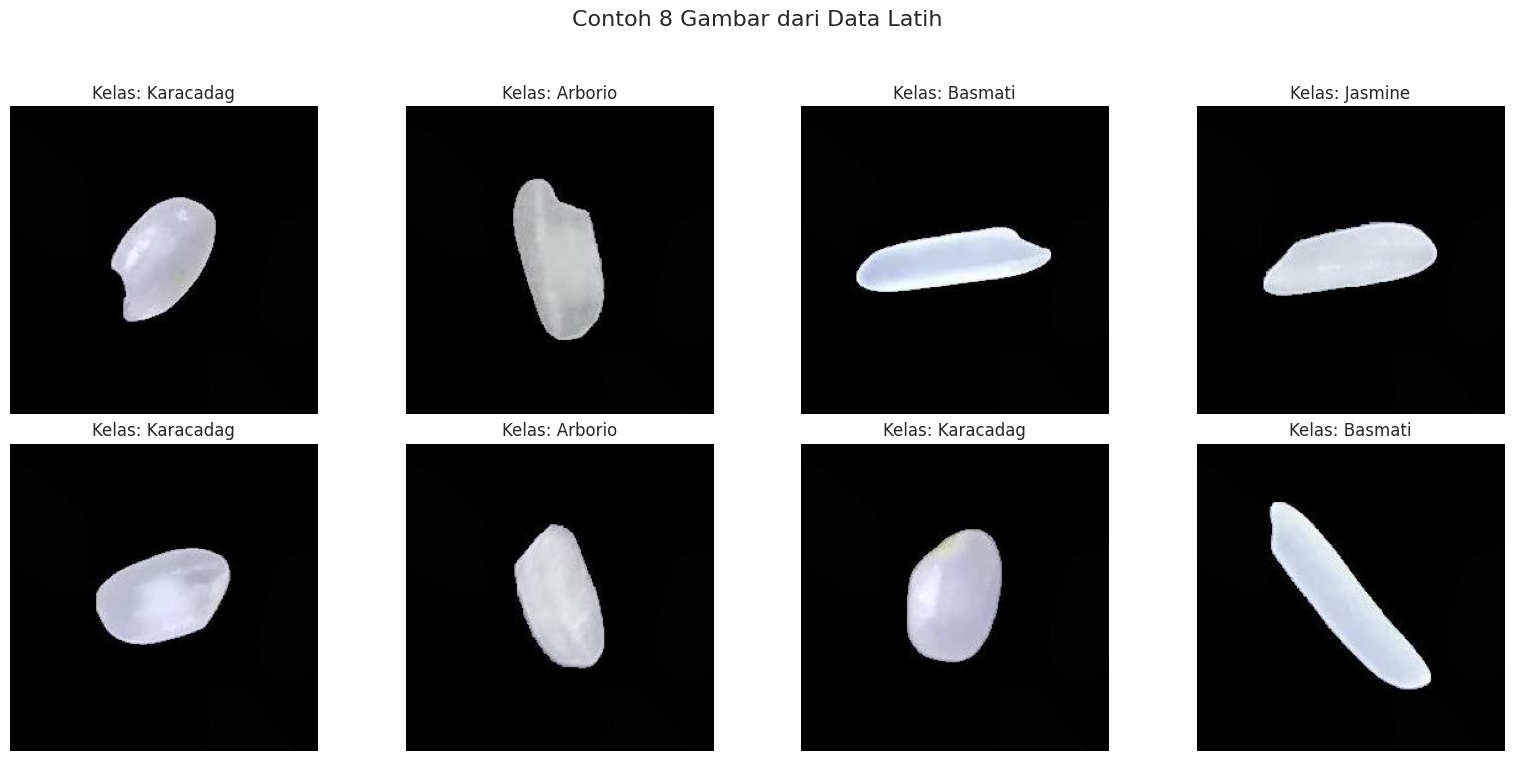

In [12]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Tentukan path ke folder data latih
train_dir = '/content/rice-dataset/split_data/train' # Ganti jika path Anda berbeda

# 2. Dapatkan daftar semua nama kelas (subfolder)
try:
    class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
except FileNotFoundError:
    print(f"Error: Direktori tidak ditemukan di '{train_dir}'")
    print("Pastikan variabel 'train_dir' sudah benar.")
    class_names = []

# 3. Jangan jalankan jika tidak ada kelas yang ditemukan
if class_names:
    # Siapkan area plot (figure) dengan ukuran yang sesuai
    # plt.subplots(baris, kolom, ...)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Judul utama untuk keseluruhan plot
    fig.suptitle('Contoh 8 Gambar dari Data Latih', fontsize=16)

    # Ratakan array 'axes' agar mudah di-loop
    axes = axes.flatten()

    # 4. Loop sebanyak 8 kali untuk menampilkan 8 gambar
    for i, ax in enumerate(axes):
        # Pilih satu kelas secara acak 🎲
        random_class = random.choice(class_names)
        class_path = os.path.join(train_dir, random_class)

        # Pilih satu gambar secara acak dari folder kelas tersebut
        image_files = os.listdir(class_path)
        if image_files: # Pastikan folder tidak kosong
            random_image_name = random.choice(image_files)
            image_path = os.path.join(class_path, random_image_name)

            # Baca gambar menggunakan matplotlib
            img = mpimg.imread(image_path)

            # Tampilkan gambar di subplot yang sesuai 🖼️
            ax.imshow(img)
            ax.set_title(f"Kelas: {random_class}") # Set judul subplot dengan nama kelas
            ax.axis('off') # Sembunyikan sumbu (garis x dan y) agar lebih rapi
        else:
            ax.set_title(f"Kelas: {random_class}\n(Kosong)")
            ax.axis('off')

    # 5. Rapikan layout dan tampilkan plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

#Preprocessing Citra

In [13]:
# Membuat ImageDataGenerator dengan augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk data validasi dan test (hanya rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Menyiapkan generator untuk setiap set data
TARGET_SIZE = (150, 150)
BATCH_SIZE = 64

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Tidak perlu di-shuffle untuk evaluasi
)

Found 52500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


#Training Model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
model = Sequential([
    # Blok 1
    Conv2D(32, (3,3), padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Blok 2
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2,2),

    # Blok 3
    Conv2D(128, (3,3), padding='same'), # Hapus blok Conv2D ke-4
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2,2),

    # Flatten
    Flatten(),

    # Dense layer yang lebih kecil
    Dense(256, activation='relu'), # Kurangi dari 512 ke 256
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(5, activation='softmax')
])

# Menampilkan ringkasan model
model.summary()

# Compile model dengan learning rate yang lebih rendah
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # BARU: Learning rate diturunkan
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,713,541 (40.87 MB)

 Trainable params: 10,712,581 (40.87 MB)

 Non-trainable params: 960 (3.75 KB)

In [15]:
# 1. Callback untuk MENYIMPAN model TERBAIK secara otomatis
#    Model hanya akan disimpan jika 'val_loss'-nya lebih rendah dari epoch sebelumnya.
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback untuk mengurangi learning rate secara otomatis
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Pantau loss di data validasi
    factor=0.2,         # Kurangi LR sebesar 80% (1 - 0.2)
    patience=3,         # Tunggu 3 epoch sebelum mengurangi LR
    min_lr=0.00001,     # Batas LR terendah
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',  # Nama file untuk menyimpan model terbaik
    monitor='val_loss',           # Metrik yang dipantau
    save_best_only=True,          # Hanya simpan jika performa membaik
    mode='min',                   # Mode 'min' karena loss yang lebih rendah lebih baik
    verbose=1
)

# 2. Callback untuk MENGHENTIKAN training jika tidak ada kemajuan
#    Training akan berhenti jika 'val_loss' tidak membaik selama 5 epoch.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,                  # Toleransi epoch sebelum berhenti
    restore_best_weights=True,    # Kembalikan bobot model ke versi terbaik
    mode='min',
    verbose=1
)

# Melatih model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr] # Tambahkan di sini
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8305 - loss: 0.4747
Epoch 1: val_loss improved from inf to 0.69075, saving model to best_model.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 336s 398ms/step - accuracy: 0.8306 - loss: 0.4744 - val_accuracy: 0.7548 - val_loss: 0.6908 - learning_rate: 5.0000e-04
Epoch 2/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9666 - loss: 0.1026
Epoch 2: val_loss did not improve from 0.69075
821/821 ━━━━━━━━━━━━━━━━━━━━ 323s 393ms/step - accuracy: 0.9666 - loss: 0.1025 - val_accuracy: 0.6996 - val_loss: 0.9568 - learning_rate: 5.0000e-04
Epoch 3/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9735 - loss: 0.0797
Epoch 3: val_loss improved from 0.69075 to 0.31911, saving model to best_model.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 324s 395ms/step - accuracy: 0.9735 - loss: 0.0797 - val_accuracy: 0.8841 - val_loss: 0.3191 - learning_rate: 5.0000e-04
Epoch 4/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9784

#Evaluasi Model


Evaluasi Model pada Test Set:
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9914 - loss: 0.0250
Test Accuracy: 97.85%
Test Loss: 0.0596


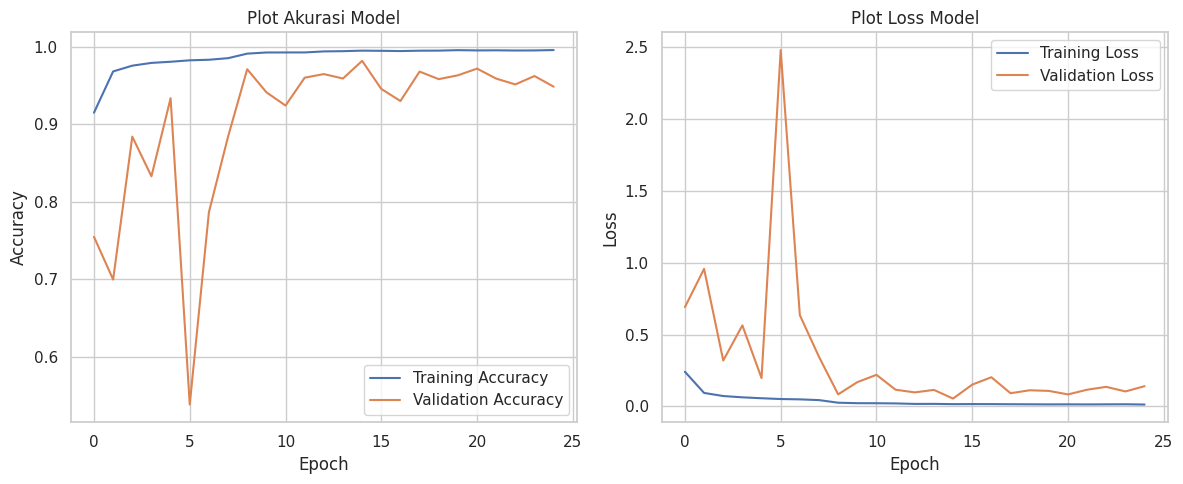

In [16]:
# Evaluasi model pada test set
print("\nEvaluasi Model pada Test Set:")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Plot Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Plot Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##Save model utuk evaluasi

In [22]:
# 1. Menyimpan dalam format SavedModel (format default)
SAVED_MODEL_DIR = "saved_model_rice"
model.export(SAVED_MODEL_DIR)
print(f"Model berhasil disimpan dalam format SavedModel di direktori: {SAVED_MODEL_DIR}")

# 2. Konversi ke TensorFlow Lite (TF-Lite)
TFLITE_MODEL_NAME = "rice_model.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
tflite_model = converter.convert()

with open(TFLITE_MODEL_NAME, 'wb') as f:
    f.write(tflite_model)
print(f"Model berhasil dikonversi ke format TF-Lite dengan nama: {TFLITE_MODEL_NAME}")

Saved artifact at 'saved_model_rice'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136188476838096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476838864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476840784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476838480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476838288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476839824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476840976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476841360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476841744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136188476840016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13618847684155

In [23]:
# 3. Konversi ke TensorFlow.js (TFJS)
#!pip install tensorflowjs

TFJS_MODEL_DIR = "tfjs_model_rice"
!tensorflowjs_converter --input_format=tf_saved_model {SAVED_MODEL_DIR} {TFJS_MODEL_DIR}

print(f"Model berhasil dikonversi ke format TFJS di direktori: {TFJS_MODEL_DIR}")

2025-09-08 08:18:53.203591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757319533.223446   47332 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757319533.229521   47332 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757319533.245354   47332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757319533.245390   47332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757319533.245396   47332 computation_placer.cc:177] computation placer alr

In [30]:
# Evaluasi model pada train set
print("\nEvaluasi Model pada Train Set:")
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")


Evaluasi Model pada Train Set:
821/821 ━━━━━━━━━━━━━━━━━━━━ 299s 363ms/step - accuracy: 0.9959 - loss: 0.0144
Train Accuracy: 99.57%
Train Loss: 0.0143



           CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Arborio       0.92      1.00      0.96      3000
     Basmati       1.00      0.99      0.99      3000
      Ipsala       0.98      1.00      0.99      3000
     Jasmine       1.00      0.91      0.95      3000
   Karacadag       1.00      0.99      1.00      3000

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000


              CONFUSION MATRIX


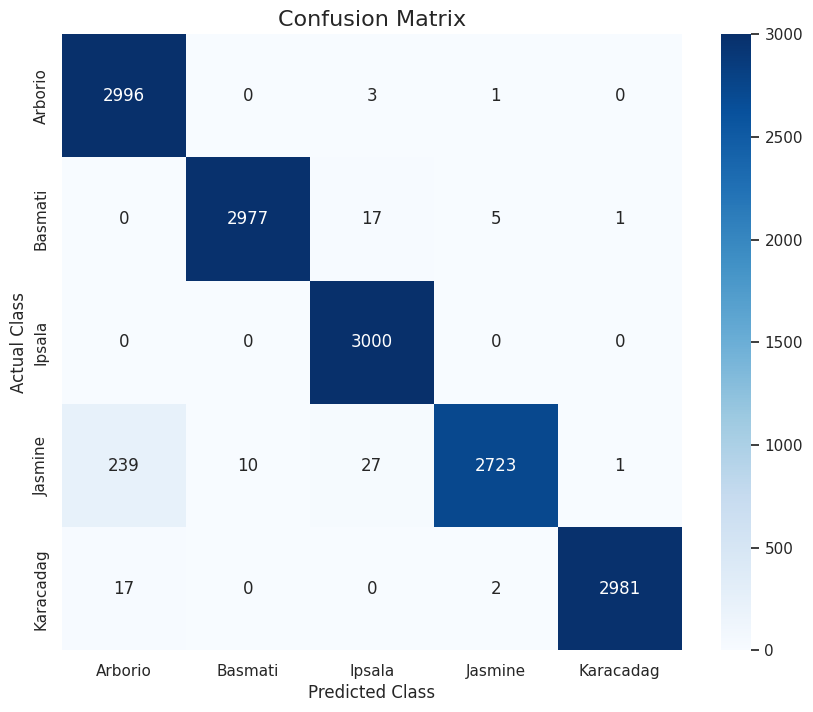

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# 1. Muat kembali model yang sudah dilatih
# Pastikan variabel SAVED_MODEL_DIR dan test_generator sudah ada dari langkah sebelumnya
try:
    SAVED_MODEL_DIR
    test_generator
except NameError:
    print("Pastikan Anda sudah menjalankan sel kode training dan preprocessing sebelumnya.")
    print("Variabel 'SAVED_MODEL_DIR' dan 'test_generator' tidak ditemukan.")
else:
    # Load the SavedModel
    loaded_model = tf.saved_model.load(SAVED_MODEL_DIR)
    # Get the prediction function from the loaded model
    infer = loaded_model.signatures["serving_default"]


    # 2. Lakukan prediksi pada seluruh data test
    # Langkah ini bisa memakan waktu beberapa saat
    # Need to iterate through the test generator to get batches and predict
    predictions = []
    y_true = []
    for i in range(len(test_generator)):
        x, y = test_generator[i]
        # Convert input to TensorFlow tensor
        x_tensor = tf.constant(x, dtype=tf.float32)
        # Get predictions from the loaded SavedModel's serving_default signature
        batch_predictions = infer(x_tensor)[list(infer(x_tensor).keys())[0]].numpy() # Access the output directly
        predictions.extend(batch_predictions)
        y_true.extend(np.argmax(y, axis=1)) # Assuming one-hot encoded labels

    predictions = np.array(predictions)
    y_true = np.array(y_true)

    # Ambil kelas dengan probabilitas tertinggi
    y_pred = np.argmax(predictions, axis=1)

    # 3. Dapatkan nama-nama kelas
    class_names = list(test_generator.class_indices.keys())

    # --- MEMBUAT CLASSIFICATION REPORT ---
    print("\n" + "="*60)
    print("           CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names))


    # --- MEMBUAT CONFUSION MATRIX ---
    print("\n" + "="*60)
    print("              CONFUSION MATRIX")
    print("="*60)

    # Buat confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualisasikan confusion matrix menggunakan heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix (Test Data)', fontsize=16)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

#Testing

Daftar Kelas: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


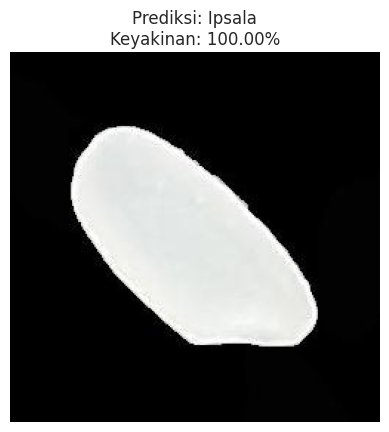


--- BUKTI INFERENSI ---
Gambar: /content/rice-dataset/split_data/test/Ipsala/Ipsala (1002).jpg
Hasil Prediksi Kelas: Ipsala
Tingkat Keyakinan: 100.00%


In [21]:
# Mendapatkan daftar kelas dari generator
class_names = list(train_generator.class_indices.keys())
print("Daftar Kelas:", class_names)

# Fungsi untuk memprediksi gambar
def predict_image(image_path, loaded_saved_model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=TARGET_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Buat batch
    img_array /= 255.0 # Rescale

    # Get the prediction function from the loaded SavedModel's serving_default signature
    infer = loaded_saved_model.signatures["serving_default"]
    predictions = infer(tf.constant(img_array, dtype=tf.float32))[list(infer(tf.constant(img_array, dtype=tf.float32)).keys())[0]].numpy()

    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    return predicted_class, confidence

# Muat kembali model SavedModel using tf.saved_model.load
loaded_saved_model = tf.saved_model.load(SAVED_MODEL_DIR)

# Ambil satu gambar acak dari test set untuk diuji
# Path gambar sampel telah disesuaikan dengan dataset sepatu
sample_image_path = "/content/rice-dataset/split_data/test/Ipsala/Ipsala (1002).jpg" # Contoh path

# Lakukan prediksi
predicted_class, confidence = predict_image(sample_image_path, loaded_saved_model)

# Tampilkan hasil inferensi
plt.imshow(plt.imread(sample_image_path))
plt.title(f"Prediksi: {predicted_class}\nKeyakinan: {confidence:.2f}%")
plt.axis('off')
plt.show()

print("\n--- BUKTI INFERENSI ---")
print(f"Gambar: {sample_image_path}")
print(f"Hasil Prediksi Kelas: {predicted_class}")
print(f"Tingkat Keyakinan: {confidence:.2f}%")

#Save Zip

In [26]:
!zip -r saved_model_rice.zip /content/saved_model_rice

  adding: content/saved_model_rice/ (stored 0%)
  adding: content/saved_model_rice/saved_model.pb (deflated 88%)
  adding: content/saved_model_rice/assets/ (stored 0%)
  adding: content/saved_model_rice/fingerprint.pb (stored 0%)
  adding: content/saved_model_rice/variables/ (stored 0%)
  adding: content/saved_model_rice/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model_rice/variables/variables.index (deflated 70%)


In [27]:
!zip -r tfjs_model_rice.zip /content/tfjs_model_rice

  adding: content/tfjs_model_rice/ (stored 0%)
  adding: content/tfjs_model_rice/group1-shard8of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard9of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard2of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/model.json (deflated 91%)
  adding: content/tfjs_model_rice/group1-shard6of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard4of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard3of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard5of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard1of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard11of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard7of11.bin (deflated 7%)
  adding: content/tfjs_model_rice/group1-shard10of11.bin (deflated 7%)


In [5]:
!pip install -q pipreqs

In [16]:
!pip freeze > requirements.txt

In [13]:
!cat /content/requirements.txt